## Code to work with ATM data along the flowline of Zachariae Isstrom

**by Jukes Liu**

**June 2019 ICESat-2 Hackweek**


In [11]:
#IMPORT PACKAGES
import os
import glob
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pyproj

Read in ATM elevation CSV files into dataframes and each variable into 1D numpy arrays:

In [12]:
#get all the relevant csv files as a list and sort in order of the flight path
filelist = glob.glob("/home/jovyan/xtrak/data/*2014*.csv")
filelist.sort(reverse=True)

#create an empty DataFrame to hold the stitched together ATM data along the profile
df_total = pd.DataFrame()

#for each csv file
for file in filelist:
    #print(file)
    #read the csv file into a pandas DataFrame
    csv_df = pd.read_csv(file, skiprows=9)
    
    #slice it to only keep Lat, Long, Ellipsoid Height
    df_slice = csv_df.loc[:, csv_df.keys()[1]: csv_df.keys()[3]]
    #print(df_slice)
    
    #concatenate (join) it to the df_total
    df_total = pd.concat([df_slice, df_total])

#check that we have all the data properly stitched together:
#print(df_total)

#Read latitude from DataFrame into 1D array
ATM_lat = df_total.loc[:, df_total.keys()[0]].values
#print(ATM_lat)

#Read longitude from DataFrame into 1D Array
ATM_long = df_total.loc[:, df_total.keys()[1]].values
#print(ATM_long)

#Read elevation from DataFrame into 1D Array
ATM_elev = df_total.loc[:, df_total.keys()[2]].values

#check the elevation data:
#for i in range(len(ATM_elev)):
    #print(i, ATM_elev[i])

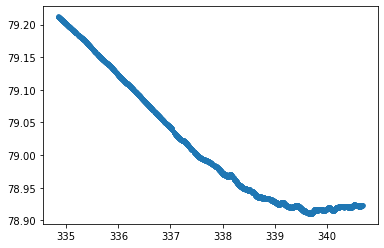

In [24]:
df_total.shape
%matplotlib inline
plt.plot(df_total.iloc[:,1],df_total.iloc[:,0],'.')

Reproject lat and long into Greenland Polar Stereo coordinates (ESPG: 3413)

[397913.47706814 397915.70409007 397917.94624422 ... 521563.18496156
 521506.26241972 521554.12880888]
[-1102425.77908309 -1102341.5766936  -1102257.36808201 ...
 -1084640.72154964 -1084535.5284331  -1084623.97262617]


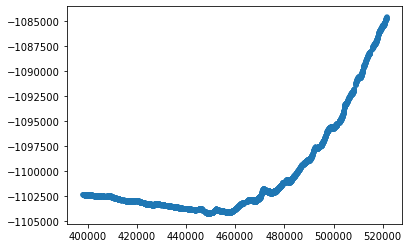

In [27]:
#REPROJECT LAT LONG INTO GREENLAND POLAR STEREO(ESPG: 3413)

#Coordinate transformation function written by Fernando Paolo:
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

#use the function to transform into Greenland Polar Stereo (PS_x, PS_y)
PS_coords = transform_coord(4326, 3413, ATM_long, ATM_lat)
PS_x = PS_coords[0]
PS_y = PS_coords[1]
print(PS_x)
print(PS_y)
plt.plot(PS_x,PS_y,'.')

Calculate distance along the flowline:

In [28]:
#create an empty array to contain the distance along flow 
dist_along = np.empty(len(ATM_lat), dtype=float)

#for each lat-long point:
for i in range(len(ATM_lat)):
    #for the first point, set distance along flow to 0 m
    if i == 0:
        dist_along[i] = 0.0
    
    #for all other subsequent points:
    else:
        #calculate distance from the last point
        #in geodetic
        #long_diff = ATM_long[i] - ATM_long[i-1]
        #lat_diff = ATM_lat[i] - ATM_lat[i-1]
        #print(long_diff, lat_diff)
        
        #convert distance change from deg to meters
        #Length in meters of 1° of latitude = always 111.32 km
        #Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

        #x = 40075000.0 *math.cos(long_diff)/ 360.0
        #y = 111320.0*(lat_diff)
        #print(x, y)
        
        #in North PS, no conversion needed
        x_diff = PS_x[i] - PS_x[i-1]
        y_diff = PS_y[i] - PS_y[i-1]
        #print(x_diff, y_diff)
                
        #calculate distance from the previous point using the distance formula:
        #in meters using geodetic
        #dist_last = math.sqrt((x**2)+(y**2))
        #print(dist_last)
        
        #in km using PS
        dist_last = math.sqrt((x_diff**2)+(y_diff**2))
        
        #add it to the previous distance along the track to get the cumulative distance
        dist_along[i] = dist_last + dist_along[i-1]

    #check the array of distance along the track in meters:
    #print(dist_along[i], ATM_elev[i])

Plot the elevation profile along the flowline:

FigureCanvasNbAgg()

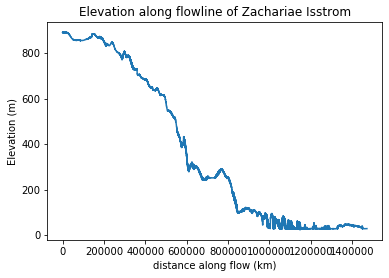

In [29]:
%matplotlib widget

plt.plot(dist_along, ATM_elev)
plt.ylabel('Elevation (m)')
plt.xlabel('distance along flow (km)')
plt.title('Elevation along flowline of Zachariae Isstrom')
plt.show()

Plot the horizontal footprint with elevation color coded:

In [6]:
%matplotlib widget

plt.scatter(ATM_long, ATM_lat, c=ATM_elev,cmap='plasma')
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.title('ATM flyover along Zachariae Isstrom')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
plt.show()

FigureCanvasNbAgg()

Final data extracted into arrays:
+ ATM_long: longitude of elev points
+ ATM_lat: latitude of elev points
+ PS_x: x-coords of elev points in Greenland Polar Stereo
+ PS_y: y-coords of elev points in Greenland Polar Stereo
+ ATM_elev: elevation points with z in meters
+ dist_along: distance along the flowline in km

...and recombined into a dataframe:

In [7]:
variables = [ATM_long, ATM_lat, PS_x, PS_y, ATM_elev, dist_along]
indices = ['ATM_long', "ATM_lat", "PS_x", "PS_y", "ATM_elev", "dist_along"]

#create DataFrame from these variables
final_data = pd.DataFrame(variables)
final_data = final_data.transpose()
final_data.columns = indices
print(final_data.head())

     ATM_long    ATM_lat           PS_x          PS_y  ATM_elev  dist_along
0  334.846721  79.211271  397913.477068 -1.102426e+06  891.4235    0.000000
1  334.848221  79.211989  397915.704090 -1.102342e+06  891.6056   84.231835
2  334.849722  79.212707  397917.946244 -1.102257e+06  891.7156  168.470291
3  334.848567  79.212155  397916.203061 -1.102322e+06  891.6397  233.240595
4  334.848296  79.211153  397948.158670 -1.102427e+06  891.1921  342.853729


In [10]:
final_data.to_csv('atmZach04_18_19.csv',index=False)